In [45]:
pip install shap 


Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


In [48]:
df = pd.read_csv("healthcare_dataset_cleaned.csv")

# Convert dates again
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce")
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce")

print("✅ df reset. Shape:", df.shape)


✅ df reset. Shape: (54966, 15)


In [49]:
# ==========================================
# MODULE 2: FEATURE ENGINEERING + PREP
# ==========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

print("\n===== MODULE 2: FEATURE ENGINEERING =====\n")

# --------------------------------------------------
# 1. FIX DATE COLUMNS & CREATE LENGTH OF STAY
# --------------------------------------------------

# Convert to datetime
date_cols = ["Date of Admission", "Discharge Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Create Length of Stay
df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

print("✅ Length of Stay created successfully.\n")


# --------------------------------------------------
# 2. OUTLIER DETECTION (IQR METHOD)
# --------------------------------------------------

def detect_outliers_iqr(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_summary[col] = list(outliers)
        print(f"{col}: {len(outliers)} outliers detected.")
    return outlier_summary

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outliers = detect_outliers_iqr(df, numeric_cols)

print("\n✅ Outlier detection completed.\n")


# --------------------------------------------------
# 3. HANDLE CATEGORICAL ENCODING (SMART + SAFE)
# --------------------------------------------------

object_cols = df.select_dtypes(include="object").columns.tolist()
print("Object columns found:", object_cols)

# Label Encode small-cardinality columns (<=10 unique)
label_encode_cols = [col for col in object_cols if df[col].nunique() <= 10]

# Target Encode high-cardinality columns (>10 unique)
target_encode_cols = [col for col in object_cols if df[col].nunique() > 10]

# ---- Label Encoding ----
le = LabelEncoder()
for col in label_encode_cols:
    df[col] = le.fit_transform(df[col])
print("\nLabel Encoded:", label_encode_cols)

# ---- Target Encoding ----
for col in target_encode_cols:
    means = df.groupby(col)["Billing Amount"].mean()
    df[col] = df[col].map(means)
print("Target Encoded:", target_encode_cols)

print("\n✅ All categorical encoding completed successfully.\n")


# --------------------------------------------------
# 4. PREPARE FINAL NUMERIC FEATURE MATRIX
# --------------------------------------------------

y = df["Billing Amount"]

# Drop target and any impossible features
X = df.drop(["Billing Amount"], axis=1)

# Convert DATETIME → numeric timestamps
datetime_cols = X.select_dtypes(include=["datetime64[ns]"]).columns
for col in datetime_cols:
    X[col] = X[col].astype("int64") // 10**9

# Ensure ALL features numeric
X = X.select_dtypes(include=[np.number])

print("✅ Final feature matrix prepared (numeric only).")
print(f"Final number of features: {X.shape[1]}\n")


# --------------------------------------------------
# 5. FEATURE SELECTION (Random Forest Importance)
# --------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("✅ Random Forest Feature Importance Computed.\n")
print(feature_importances.head(20))



===== MODULE 2: FEATURE ENGINEERING =====

✅ Length of Stay created successfully.

Age: 0 outliers detected.
Billing Amount: 0 outliers detected.
Room Number: 0 outliers detected.
Length of Stay: 0 outliers detected.

✅ Outlier detection completed.

Object columns found: ['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']

Label Encoded: ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
Target Encoded: ['Name', 'Doctor', 'Hospital']

✅ All categorical encoding completed successfully.

✅ Final feature matrix prepared (numeric only).
Final number of features: 15

✅ Random Forest Feature Importance Computed.

               Feature    Importance
0                 Name  9.998423e-01
7             Hospital  8.977689e-05
6               Doctor  5.529903e-05
12          Medication  2.100144e-06
9          Room Number  2.038341e-06
10 

In [50]:
from xgboost import XGBRegressor

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
print("✅ XGBoost model trained successfully.")


✅ XGBoost model trained successfully.


C:\Users\ShreYash\AppData\Local\Temp\ipykernel_13520\785022425.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample)


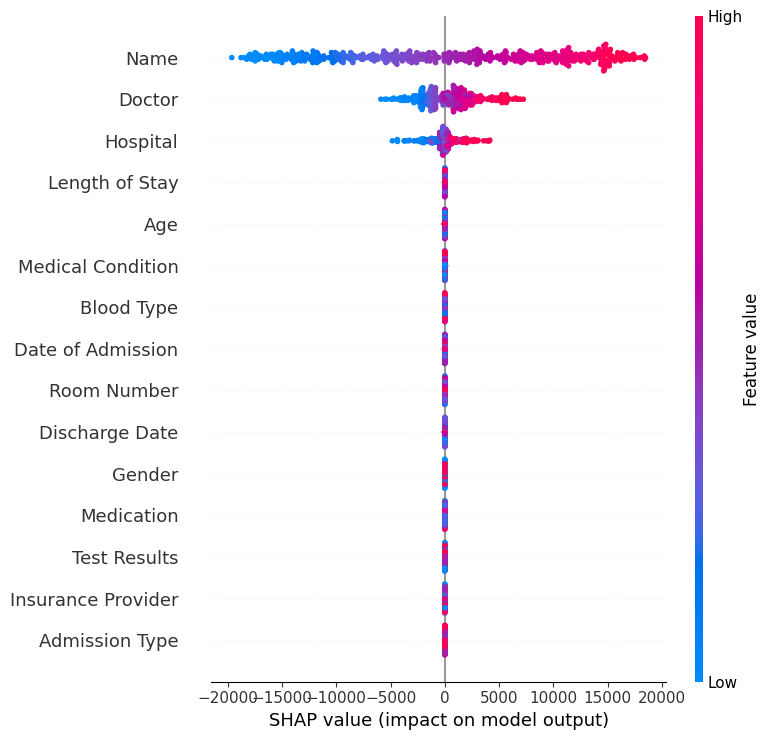

In [51]:
import shap

# Initialize fast tree-based SHAP explainer
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values ONLY on a small sample to avoid overload
X_sample = X_test.sample(500)  # 500 rows = super fast

shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample)




In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


✅ Train/Test Split Complete: (43972, 15) (10994, 15)

===== Random Forest RESULTS =====
MAE  : 4.427481382560434
MSE  : 9687.425326482356
RMSE : 98.42471908256765
R²   : 0.999952435370618

===== XGBoost RESULTS =====
MAE  : 102.01616206480288
MSE  : 40842.89793691862
RMSE : 202.09625908689804
R²   : 0.9997994640229175

===== Linear Regression RESULTS =====
MAE  : 7.031575641986505
MSE  : 3412.5707036795898
RMSE : 58.41721239223582
R²   : 0.9999832444994113

✅ Random Forest 5-Fold CV R²: 0.9997735766333353

✅ Best RF Params: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 10}

===== BEST Random Forest RESULTS =====
MAE  : 6.894335003988861
MSE  : 9519.28191414118
RMSE : 97.56680744054907
R²   : 0.9999532609438555

✅ Best XGB Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400}

===== BEST XGBoost RESULTS =====
MAE  : 83.07914274304541
MSE  : 29278.59757866215
RMSE : 171.10989912527606
R²   : 0.9998562439868467

===== MODEL COMPARISON =====
      Model        

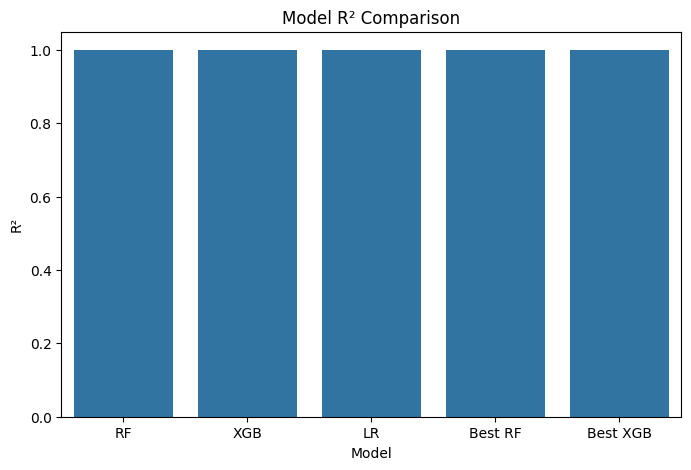

In [53]:
# ================================================================
# FULL ADVANCED MACHINE LEARNING PIPELINE
# ================================================================

# ------------------------------------------------------------
# 1. TRAIN–TEST SPLIT
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Train/Test Split Complete:", X_train.shape, X_test.shape)


# ------------------------------------------------------------
# METRICS FUNCTION
# ------------------------------------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n===== {name} RESULTS =====")
    print(f"MAE  : {mae}")
    print(f"MSE  : {mse}")
    print(f"RMSE : {rmse}")
    print(f"R²   : {r2}")
    return [mae, mse, rmse, r2]


# ------------------------------------------------------------
# 2. BASE MODELS (TRAIN + EVALUATE)
# ------------------------------------------------------------

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_metrics = evaluate_model("Random Forest", y_test, rf_pred)

# XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_pred)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_metrics = evaluate_model("Linear Regression", y_test, lr_pred)


# ------------------------------------------------------------
# 3. CROSS-VALIDATION (K-Fold)
# ------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_scores = []
for train_idx, test_idx in kf.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = rf.predict(X.iloc[test_idx])
    rf_cv_scores.append(r2_score(y.iloc[test_idx], preds))

print("\n✅ Random Forest 5-Fold CV R²:", np.mean(rf_cv_scores))


# ------------------------------------------------------------
# 4. HYPERPARAMETER TUNING (GridSearch + RandomSearch)
# ------------------------------------------------------------

# RANDOM FOREST RANDOM SEARCH
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10]
}

rf_random = RandomizedSearchCV(
    rf, rf_params,
    n_iter=10,
    scoring="r2",
    cv=3,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print("\n✅ Best RF Params:", rf_random.best_params_)

best_rf = rf_random.best_estimator_
best_rf_pred = best_rf.predict(X_test)
evaluate_model("BEST Random Forest", y_test, best_rf_pred)


# XGBOOST GRID SEARCH
xgb_params = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400],
}

xgb_grid = GridSearchCV(
    xgb, xgb_params,
    scoring="r2",
    cv=3,
    n_jobs=-1,
)

xgb_grid.fit(X_train, y_train)
print("\n✅ Best XGB Params:", xgb_grid.best_params_)

best_xgb = xgb_grid.best_estimator_
best_xgb_pred = best_xgb.predict(X_test)
evaluate_model("BEST XGBoost", y_test, best_xgb_pred)


# ------------------------------------------------------------
# 5. MODEL COMPARISON DASHBOARD
# ------------------------------------------------------------
model_scores = pd.DataFrame({
    "Model": ["RF", "XGB", "LR", "Best RF", "Best XGB"],
    "R²": [rf_metrics[3], xgb_metrics[3], lr_metrics[3],
           r2_score(y_test, best_rf_pred), r2_score(y_test, best_xgb_pred)],
    "RMSE": [rf_metrics[2], xgb_metrics[2], lr_metrics[2],
             np.sqrt(mean_squared_error(y_test, best_rf_pred)),
             np.sqrt(mean_squared_error(y_test, best_xgb_pred))]
})

print("\n===== MODEL COMPARISON =====")
print(model_scores)

plt.figure(figsize=(8, 5))
sns.barplot(data=model_scores, x="Model", y="R²")
plt.title("Model R² Comparison")
plt.show()








In [54]:
pip install xgboost==1.7.6


Note: you may need to restart the kernel to use updated packages.


C:\Users\ShreYash\AppData\Local\Temp\ipykernel_13520\3452546066.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


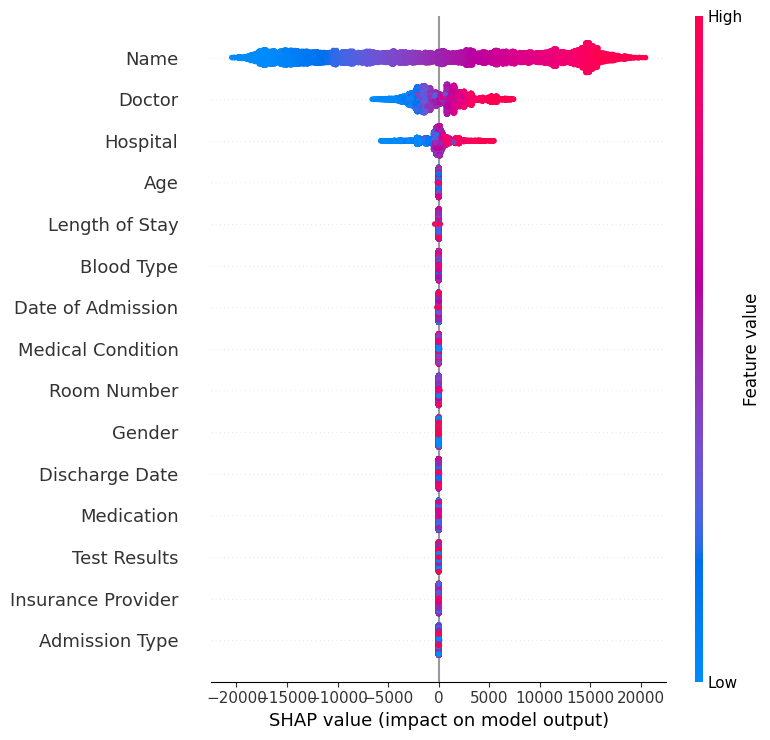

In [55]:
# ------------------------------------------------------------
# 6. SHAP EXPLAINABILITY (for XGB)
# ------------------------------------------------------------
import shap

# Create SHAP explainer using your trained XGBoost model
explainer = shap.TreeExplainer(xgb)


# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)


In [56]:
# ------------------------------------------------------------
# 7. SAVE MODELS
# ------------------------------------------------------------
pickle.dump(best_rf, open("best_random_forest.pkl", "wb"))
pickle.dump(best_xgb, open("best_xgboost.pkl", "wb"))
pickle.dump(lr, open("linear_regression.pkl", "wb"))

print("\n✅ All models saved successfully!")


# ------------------------------------------------------------
# 9. LOAD MODELS (example)
# ------------------------------------------------------------
loaded_rf = pickle.load(open("best_random_forest.pkl", "rb"))
print("✅ Loaded RF Model:", loaded_rf)


✅ All models saved successfully!
✅ Loaded RF Model: RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=300,
                      n_jobs=-1, random_state=42)
